In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Physics_Project/Brain/Healthcare AI Datasets/Brain_MRI

/content/drive/MyDrive/Physics_Project/Brain/Healthcare AI Datasets/Brain_MRI


In [4]:
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.count()

patient_id    3929
image_path    3929
mask_path     3929
mask          3929
dtype: int64

In [7]:
brain_df.head()

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0

[5 rows x 4 columns]

In [8]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [10]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [11]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 4, opacity = 0.6)
fig.show()

In [12]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [13]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

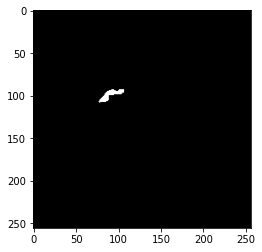

In [14]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

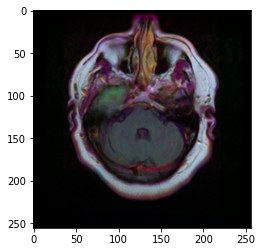

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [16]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [17]:
cv2.imread(brain_df.mask_path[623]).min()

0

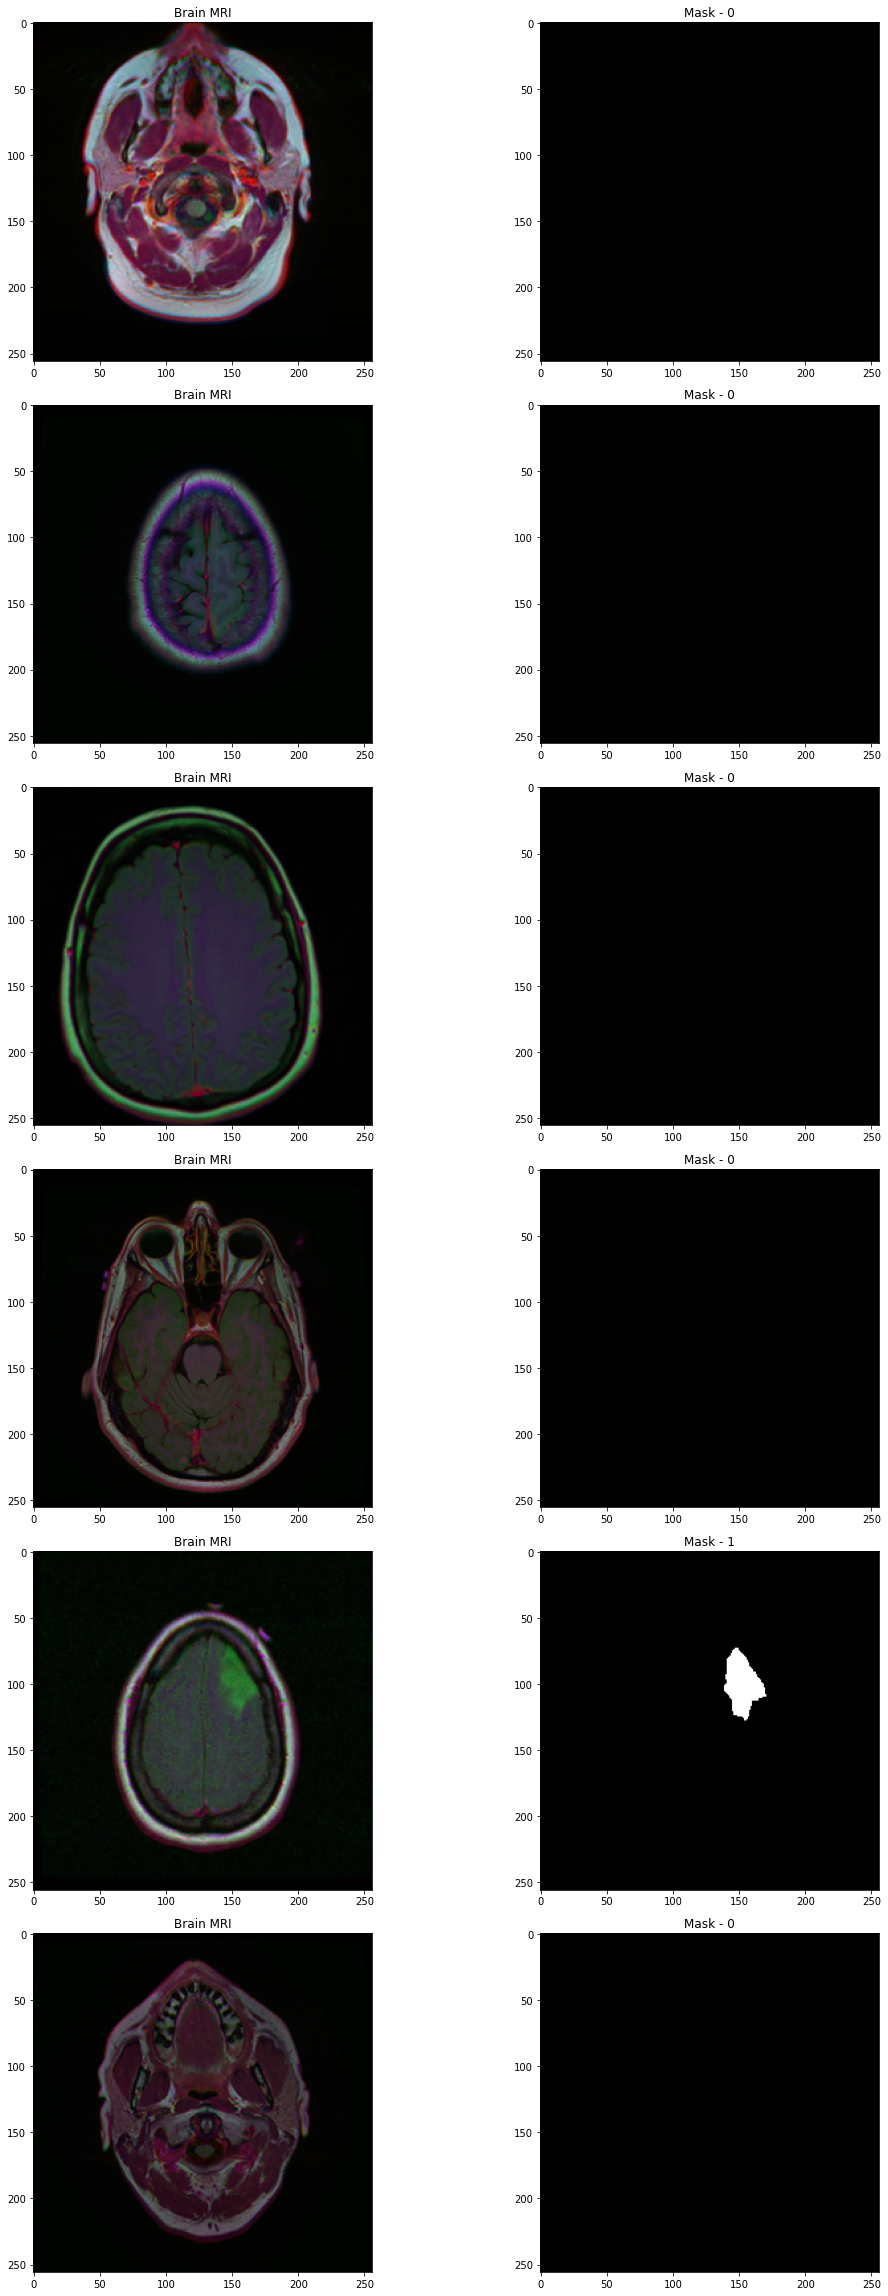

In [18]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

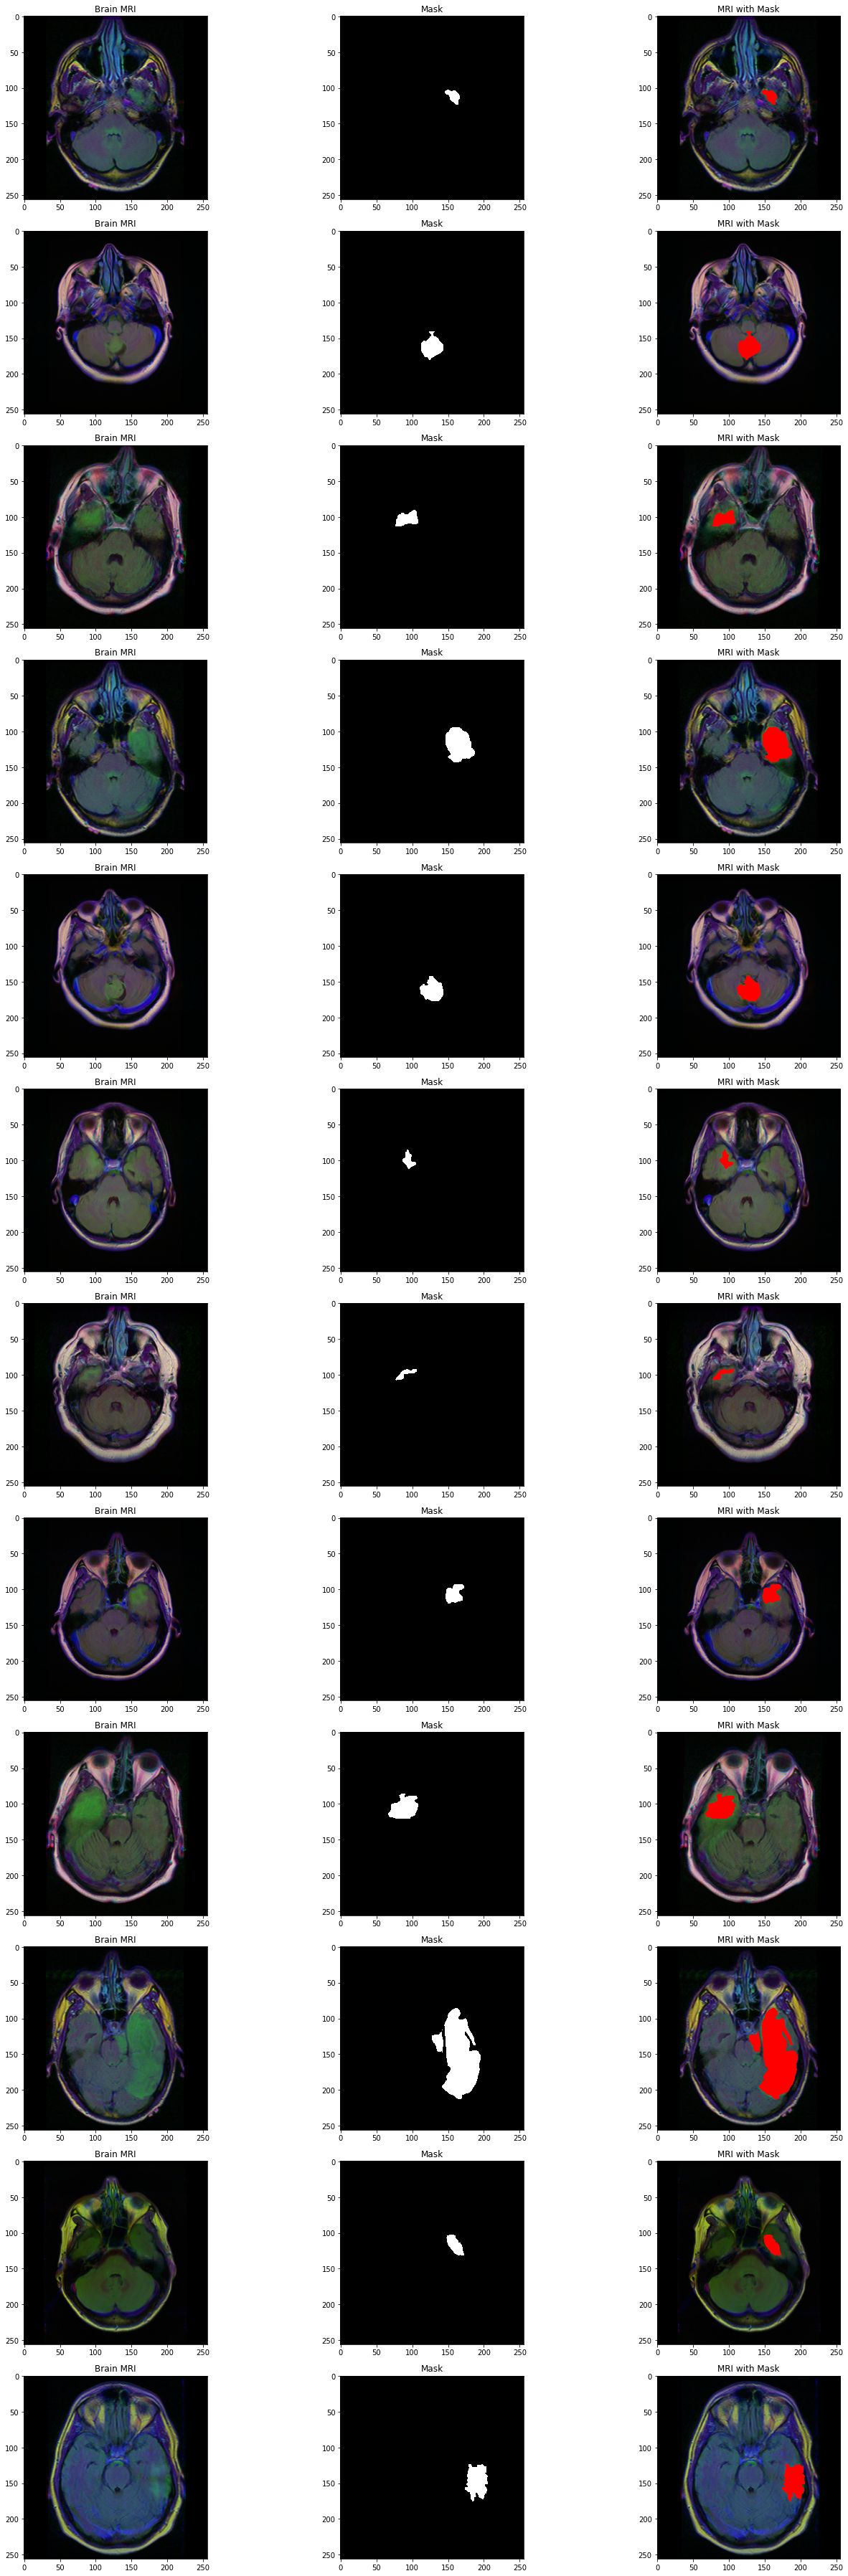

In [19]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [20]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [21]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [22]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x : str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train,test_size =0.15)

In [25]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)


In [26]:
train_generator=datagen.flow_from_dataframe(
dataframe = train,
directory='./', x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='training'
)

valid_generator=datagen.flow_from_dataframe(
dataframe = train,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)

test_generator=datagen.flow_from_dataframe(
dataframe = test,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
)


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [27]:
basemodel = ResNet50(weights='imagenet', include_top= False, input_tensor= Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 0s 0us/step


In [28]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [29]:
for layer in basemodel.layers:
  layers.trainable = False

In [30]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

In [34]:
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [35]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - 884s 5s/step - loss: 0.8742 - accuracy: 0.7113 - val_loss: 2.8344 - val_accuracy: 0.6740

Epoch 00001: val_loss improved from inf to 2.83437, saving model to classifier-resnet-weights.hdf5


In [36]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [37]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [38]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 146s 4s/step


In [39]:
test_predict.shape

(590, 2)

In [40]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [41]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

590

In [42]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.5305084745762711

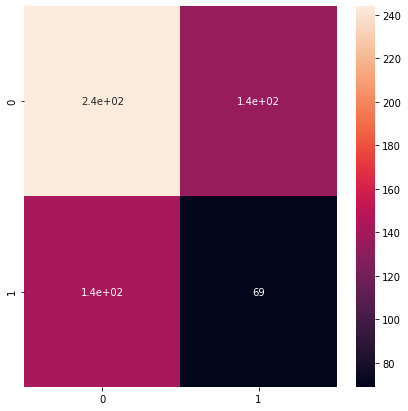

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [44]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       379
           1       0.34      0.33      0.33       211

   micro avg       0.53      0.53      0.53       590
   macro avg       0.49      0.49      0.49       590
weighted avg       0.53      0.53      0.53       590



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [45]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [47]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [48]:
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [49]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [50]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [51]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [52]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [53]:
from utilities import focal_tversky, tversky_loss, tversky

In [54]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [55]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [56]:
#history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [57]:

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [58]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [59]:
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [60]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57...  ...        0
1    TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_9.tif  ...        0
2    TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_3.tif  ...        0
3    TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_2.tif  ...        0
4    TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_30...  ...        0
..                                                 ...  ...      ...
585  TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_20...  ...        0
586  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4.tif  ...        0
587  TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_19...  ...        0
588  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_51...  ...        0
589  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_22...  ...        1

[590 rows x 3 columns]

In [61]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57...  ...        0
1  TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_9.tif  ...        0
2  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_3.tif  ...        0
3  TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_2.tif  ...        0
4  TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_30...  ...        0

[5 rows x 5 columns]

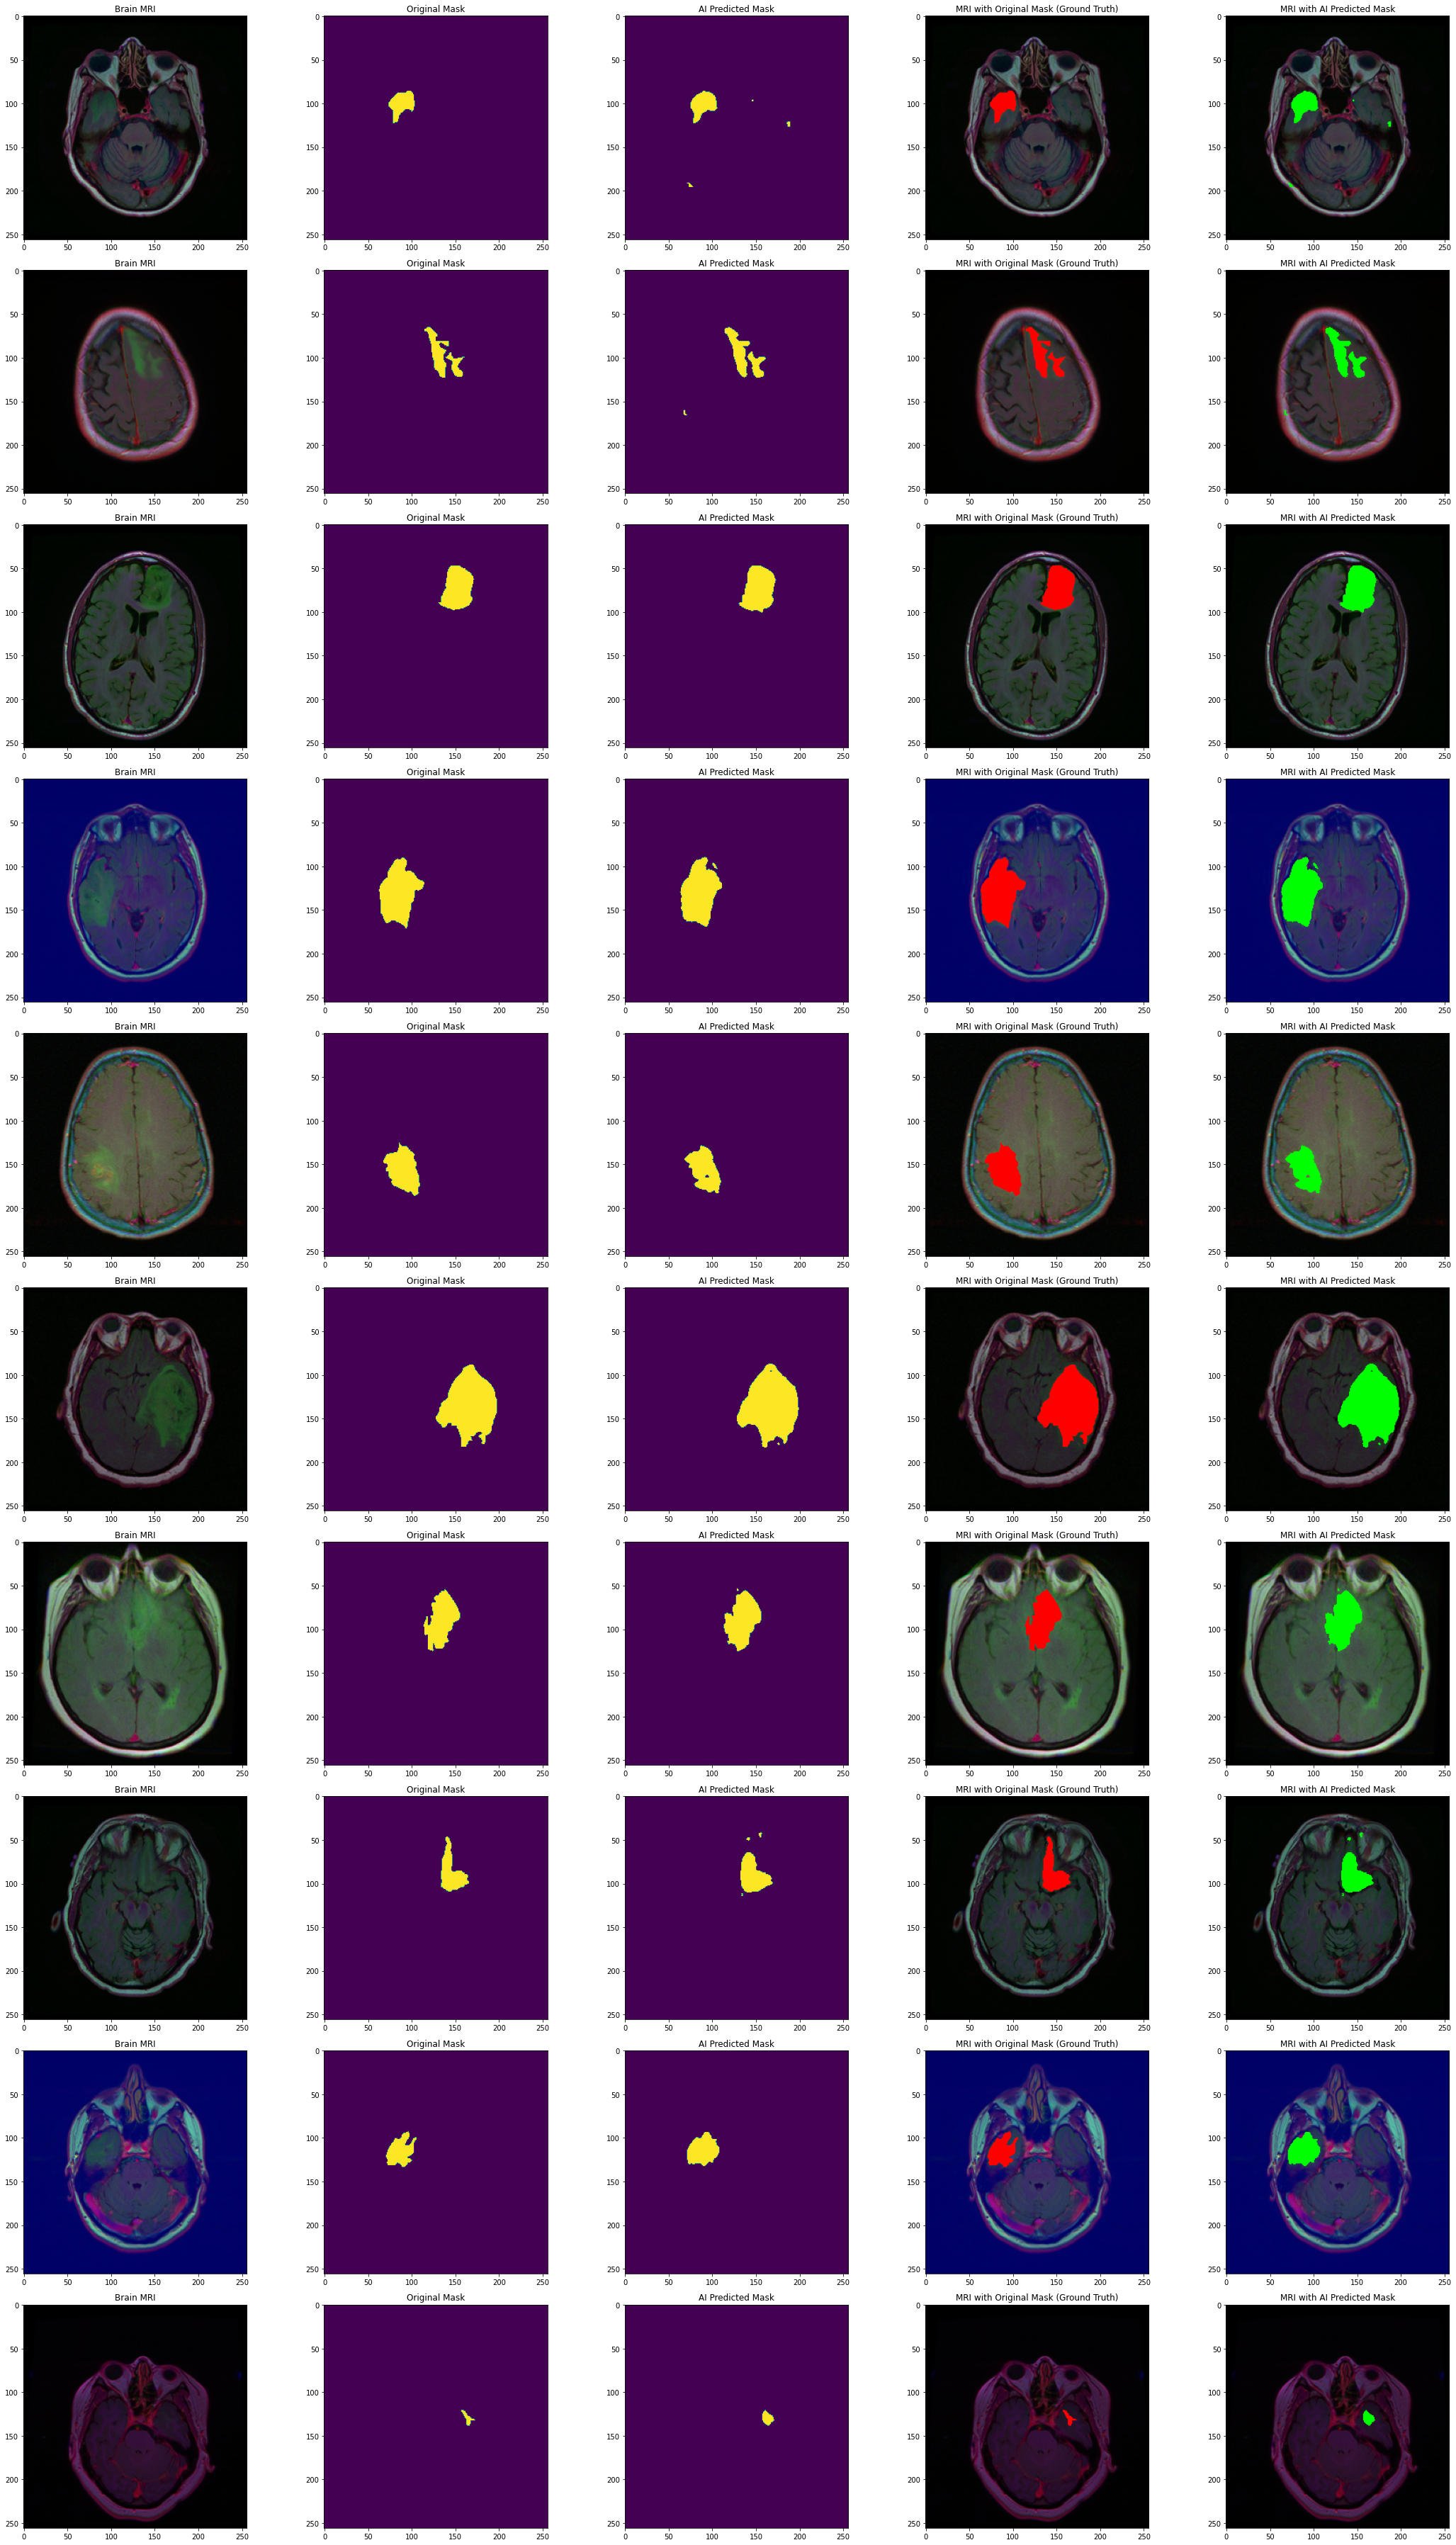

In [62]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

In [63]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

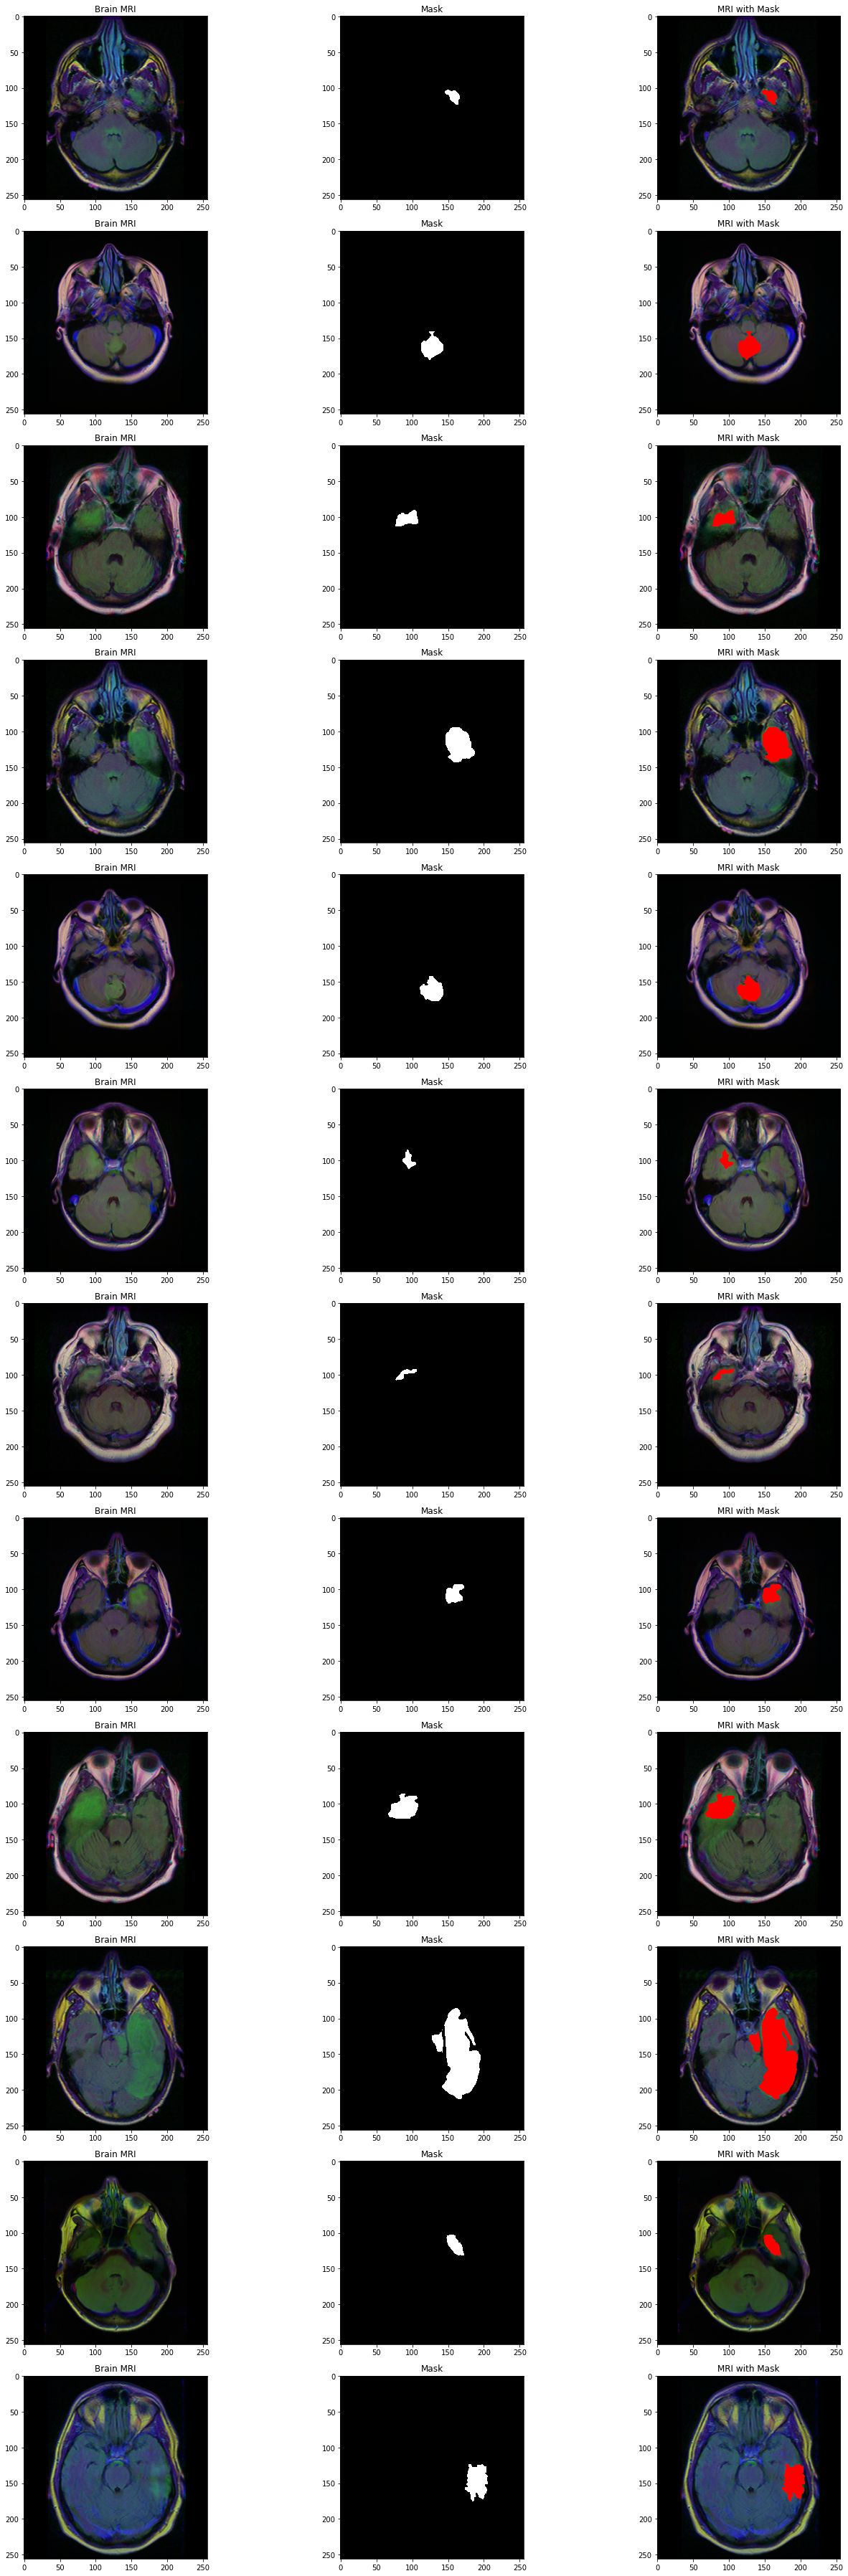

In [64]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image 
count = 0 
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images 
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image 
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')
    
    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255 
    img[mask == 255] = (255,0,0)    
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [65]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [66]:
Total parameters (original model) = 25,685,634
Total parameters (New model with added dense and dropout layers) = 25,751,426

SyntaxError: ignored

In [67]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       379
           1       0.34      0.33      0.33       211

   micro avg       0.53      0.53      0.53       590
   macro avg       0.49      0.49      0.49       590
weighted avg       0.53      0.53      0.53       590



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [69]:
count = 0 
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30:

SyntaxError: ignored